Imports

In [1]:
import os
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import sampler

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Load Data

In [3]:
diff_grid = np.load('diff_grid.npz')['arr_0']
label = np.load('diffraction_label.npz')['arr_0']

Model

Encoder

In [4]:
def conv(in_channels, out_channels):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=3, padding=1),
    nn.LeakyReLU(negative_slope=0.01, inplace=True),
    nn.BatchNorm2d(out_channels),
  )
  
def conv_max(in_channels, out_channels):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=3, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.LeakyReLU(negative_slope=0.01, inplace=True),
    nn.BatchNorm2d(out_channels),
  )

In [5]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.block1 = conv(1, 16)
    self.block2 = conv_max(16, 32)
    self.block3 = conv_max(32, 64)
    self.block4 = conv_max(64, 128)

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    return x

Decoder

In [6]:
def convTrans(in_channels, out_channels):
  return nn.Sequential(
    nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=2),
    nn.ReLU(inplace = True),
  )

def up_conv(in_channels, out_channels, padding):
  return nn.Sequential(
    nn.ConvTranspose2d(in_channels, out_channels, kernel_size=5, stride=2, padding=padding),
    nn.ReLU(inplace = True),
    nn.BatchNorm2d(out_channels),
    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
  )

In [7]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.block1 = up_conv(128, 64, 1)
    self.block2 = convTrans(64, 32)
    self.block3 = up_conv(32, 16, 2)
    self.block4 = convTrans(16, 1)

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    return x

Encoder-Decoder Model

In [8]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.encoder = Encoder()
    self.phase_decoder = Decoder()
    self.amp_decoder = Decoder()
    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()

  def forward(self, diffraction):
    latent_z = self.encoder(diffraction)
    phase = self.tanh(self.phase_decoder(latent_z))
    phase = phase*cp.pi
    amp = self.sigmoid(self.amp_decoder(latent_z))
    return phase, amp

In [9]:
summary(Model().to(device), (1,7100,7100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 16, 2366, 2366]             416
         LeakyReLU-2       [-1, 16, 2366, 2366]               0
       BatchNorm2d-3       [-1, 16, 2366, 2366]              32
            Conv2d-4         [-1, 32, 788, 788]          12,832
         MaxPool2d-5         [-1, 32, 393, 393]               0
         LeakyReLU-6         [-1, 32, 393, 393]               0
       BatchNorm2d-7         [-1, 32, 393, 393]              64
            Conv2d-8         [-1, 64, 131, 131]          51,264
         MaxPool2d-9           [-1, 64, 65, 65]               0
        LeakyReLU-10           [-1, 64, 65, 65]               0
      BatchNorm2d-11           [-1, 64, 65, 65]             128
           Conv2d-12          [-1, 128, 21, 21]         204,928
        MaxPool2d-13          [-1, 128, 10, 10]               0
        LeakyReLU-14          [-1, 128,

Training

In [18]:
lossfn =  nn.MSELoss()
def ModelLoss(preds1, targets1, preds2, targets2):
  loss1 = lossfn(preds1, targets1)
  loss2 = lossfn(preds2, targets2)

  # loss2 = nn.functional.binary_cross_entropy(preds2, targets2, reduction='mean')

  return loss1, loss2

In [12]:
PtychoModel = Model().to(device)
diff = torch.tensor(diff_grid,device=device).float()
phase = torch.tensor(label[:, 0],device=device).float()
amp = torch.tensor(label[:, 1],device=device).float()

In [23]:
num_epochs = 200
# Look into Scheduler: (varies the learning rate of optimizer) scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=, max_lr=, step_size_up=)
optimizer = torch.optim.Adam(PtychoModel.parameters(), lr=0.0002, betas=(0.9, 0.999))
for epoch in range(num_epochs):

  PtychoModel.train()
  phase_pred, amp_pred = PtychoModel(diff)
  loss1, loss2 = ModelLoss(phase_pred, phase, amp_pred, amp)
  loss = loss1+loss2

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  print("Epoch: ", (epoch+1), "Training Loss: ", round(loss.item(), 3), round(loss1.item(), 4), round(loss2.item(), 4))

RuntimeError: CUDA out of memory. Tried to allocate 1.34 GiB (GPU 0; 11.78 GiB total capacity; 8.86 GiB already allocated; 416.56 MiB free; 9.71 GiB reserved in total by PyTorch)

In [20]:
PtychoModel.eval()
phase_pred, amp_pred = PtychoModel(diff)

In [ ]:
f, ax = plt.subplots(2,2, figsize=(20, 10))
ax[0,0].imshow(phase_pred[0].cpu().detach().numpy().reshape((650,650)))
ax[0,1].imshow(amp_pred[0].cpu().detach().numpy().reshape((650,650)))
ax[1,0].imshow(phase[1].cpu().detach().numpy().reshape((650,650)))
ax[1,1].imshow(amp[1].cpu().detach().numpy().reshape((650,650)))

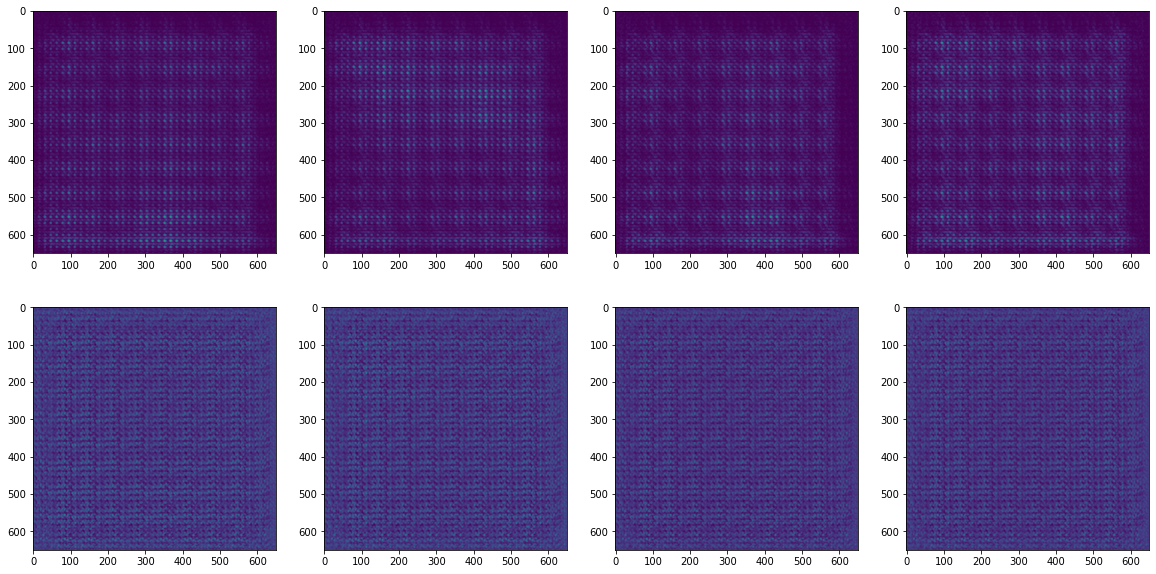

In [22]:
# f, ax = plt.subplots(2,4, figsize=(20, 10))
# ax[0,0].imshow(phase_pred[0].cpu().detach().numpy().reshape((650,650)))
# ax[1,0].imshow(amp_pred[0].cpu().detach().numpy().reshape((650,650)))
# ax[0,1].imshow(phase_pred[1].cpu().detach().numpy().reshape((650,650)))
# ax[1,1].imshow(amp_pred[1].cpu().detach().numpy().reshape((650,650)))
# ax[0,2].imshow(phase_pred[2].cpu().detach().numpy().reshape((650,650)))
# ax[1,2].imshow(amp_pred[2].cpu().detach().numpy().reshape((650,650)))
# ax[0,3].imshow(phase_pred[3].cpu().detach().numpy().reshape((650,650)))
# ax[1,3].imshow(amp_pred[3].cpu().detach().numpy().reshape((650,650)))

In [17]:
# command to check memory availability on the GPU 
!nvidia-smi

Sun Jan  1 15:39:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:D8:00.0 Off |                  N/A |
| 37%   51C    P2    37W / 250W |   8911MiB / 12066MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------